In [160]:
import torch
from torch import nn,optim
from torchvision import datasets as dsets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt
import numpy as np
from statistics import mean

# Loading data

In [161]:
batch_size = 50

train = dsets.MNIST(root = './data', train = True, transform=transforms.ToTensor(), download=True)
valid = dsets.MNIST(root = './data', train = False, transform=transforms.ToTensor(), download=True)

sample_set_size = 5000
indices = torch.randperm(len(train))[:sample_set_size]
train_loader = DataLoader(dataset = train, batch_size = batch_size, sampler=SubsetRandomSampler(indices))
val_loader = DataLoader(dataset = valid, batch_size = 10000, shuffle = True)

# Model class

In [162]:
class CNN(nn.Module):

    def __init__(self, out1 = 16, out2 = 32):
        super(CNN, self).__init__()

        self.relu = nn.ReLU()
        self.mp = nn.MaxPool2d(kernel_size=2)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=out1, kernel_size=2, padding=3, stride=1)
        self.bnorm1 = nn.BatchNorm2d(out1)

        self.conv2 = nn.Conv2d(in_channels=out1, out_channels=out2, kernel_size=2, padding=3, stride=1)
        self.bnorm2 = nn.BatchNorm2d(out2)

        self.linear1 = nn.Linear(10 * 10 * out2, 100)
        self.bnorm3 = nn.BatchNorm1d(100)
        self.linear2 = nn.Linear(100, 10)

        

        self.convblock2 = nn.Sequential(nn.Conv2d(in_channels=out1, out_channels=out2, kernel_size=2, padding=3, stride=1), 
                                        nn.BatchNorm2d(out2), 
                                        nn.ReLU(),
                                        nn.MaxPool2d(kernel_size=2))

        self.fc = nn.Sequential(nn.Linear(10 * 10 * out2, 100), nn.BatchNorm1d(100), nn.ReLU(), nn.Linear(100,10))


    def forward(self,x):
        x1 = self.conv1(x)
        x2 = self.bnorm1(x1)
        x3 = self.relu(x2)
        x4 = self.mp(x3)

        x5 = self.conv2(x4)
        x6 = self.bnorm2(x5)
        x7 = self.relu(x6)
        x8 = self.mp(x7)

        x8 = x8.view(x8.shape[0], x8.shape[1] * x8.shape[2] * x8.shape[3])
        x9 = self.linear1(x8)
        x10 = self.bnorm3(x9)
        x11 = self.linear2(x10)

        return x11

    def activations(self, x):

        x1 = self.conv1(x)
        x2 = self.bnorm1(x1)
        x3 = self.relu(x2)
        x4 = self.mp(x3)

        x5 = self.conv2(x4)
        x6 = self.bnorm2(x5)
        x7 = self.relu(x6)
        x8 = self.mp(x7)

        x8 = x8.view(x8.shape[0], x8.shape[1] * x8.shape[2] * x8.shape[3])
        x9 = self.linear1(x8)
        x10 = self.bnorm3(x9)
        x11 = self.linear2(x10)

        return x1, x3, x5, x7


# Train function

In [163]:
def train_model(model, epochs, learning_rate, final_lr, train_loader, val_loader, momentum):

    epoch_loss = []
    accuracy = []
    all_loss = []
    criterion = nn.CrossEntropyLoss()
    num_batches = len(list(train_loader))
    print(f'{num_batches} batches per epoch.')

    lr_decay = (final_lr - learning_rate) / int((3/4) * epochs)

    for epoch in range(epochs):
        model.train()
        opt = optim.SGD(model.parameters(), lr=learning_rate, momentum = momentum)

        print('EPOCH : ', epoch + 1)
        print('Batch : ', end = '')
        counter = 0
        mean_loss_list = []
        for x,y in train_loader :

            opt.zero_grad()
            yhat = model.forward(x)

            loss = criterion(yhat,y)
            mean_loss_list.append(loss.item())
            all_loss.append(loss.item())

            loss.backward()
            opt.step()

            if counter % (num_batches/20) == 0 : 
                print(str(counter) + ' --> ', end = '', flush = True)
            counter += 1

        mean_loss = mean(mean_loss_list)
        epoch_loss.append(mean_loss)

        correct = 0
        incorrect = 0

        for x,y in val_loader :
            model.eval()

            yhat = model.forward(x)

            for i in range(yhat.shape[0]):
                pred = yhat[i].argmax().item()
                actual = y[i].item()

                if pred == actual :
                    correct += 1
                else :
                    incorrect += 1
        
        acc = (correct / (correct + incorrect)) * 100
        accuracy.append(acc)

        print()
        print('Mean loss : ', mean_loss)
        print(f'Accuracy on test set : {acc} %')
        print('-' * 50)

        learning_rate = learning_rate - lr_decay

    return epoch_loss, all_loss, accuracy

# Plot activation function

In [164]:
def plot_activations(layer, rows, cols, title, size):

    fig1, ax1 = plt.subplots(nrows = rows, ncols = cols, figsize = size)
    ax1 = ax1.flatten()
    fig1.suptitle(title, size = 15)

    for var1 in range(rows * cols):
        ax1[var1].imshow(layer[0][var1].detach())
        ax1[var1].axis(False)

In [165]:
model = CNN()

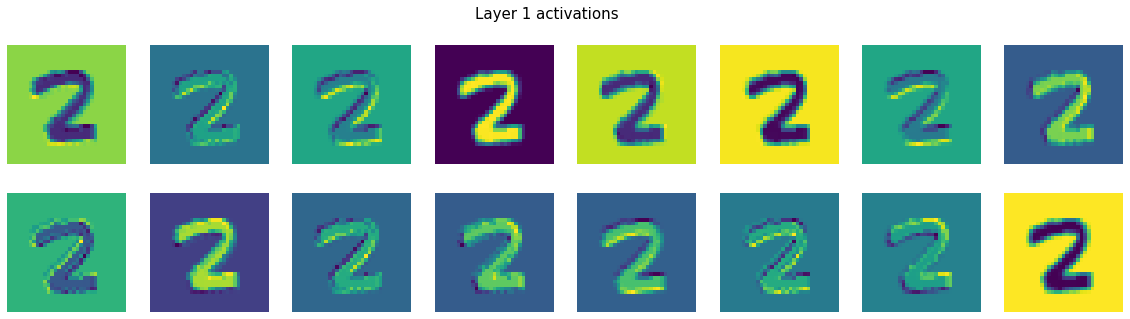

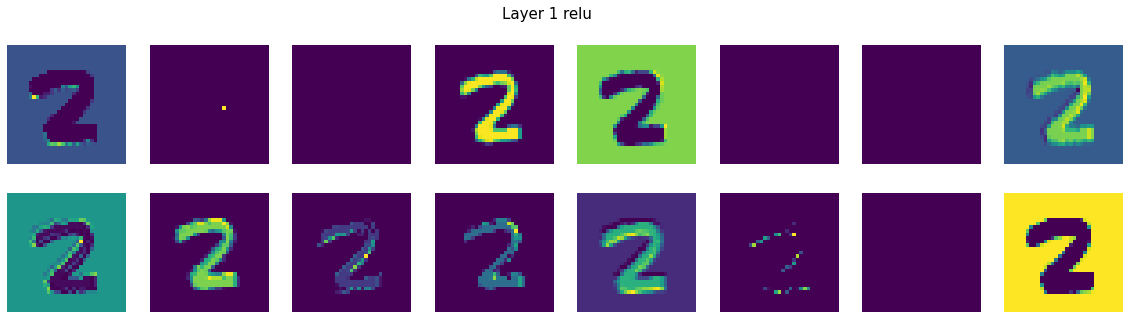

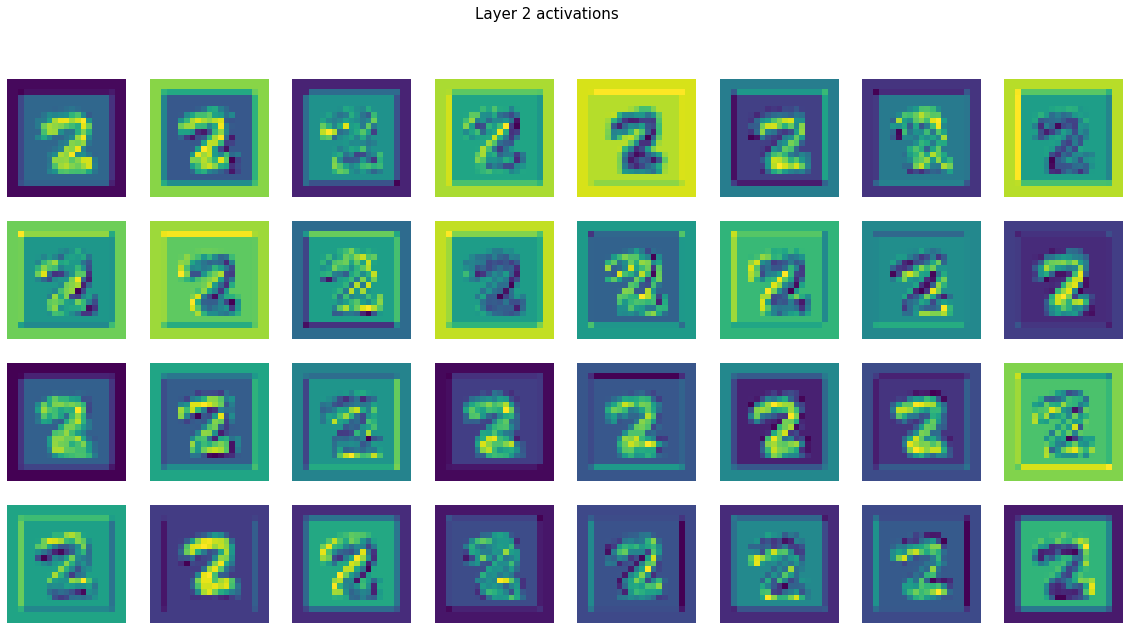

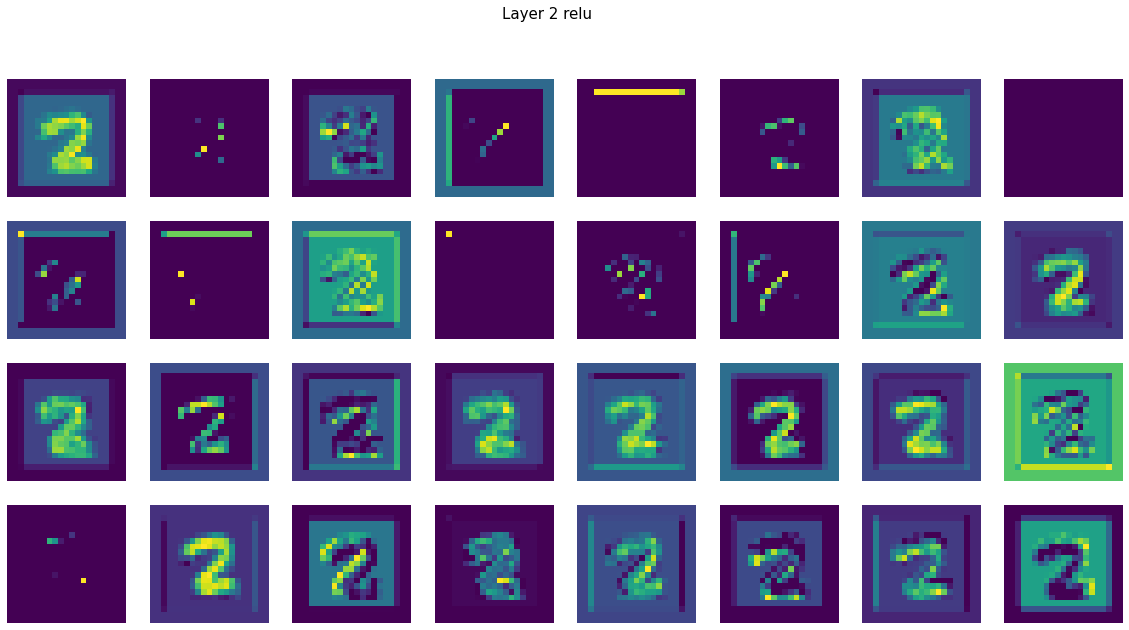

In [166]:
model.eval()
sample = train[np.random.randint(0,60000)][0].view(1,1,28,28)
layer1, relu1, layer2, relu2 = list(model.activations(sample))

plot_activations(layer1, 2, 8, 'Layer 1 activations', (20,5))
plot_activations(relu1, 2, 8, 'Layer 1 relu', (20,5))

plot_activations(layer2, 4, 8, 'Layer 2 activations', (20,10))
plot_activations(relu2, 4, 8, 'Layer 2 relu', (20,10))

In [167]:
model.train()
epochs = 5
lr = 0.0085
momentum = 0.85
loss, all_loss, acc = train_model(model = model, epochs = epochs, learning_rate = lr, final_lr = lr/5, train_loader = train_loader, val_loader = val_loader, momentum = momentum)

100 batches per epoch.
EPOCH :  1
Batch : 0 --> 5 --> 10 --> 15 --> 20 --> 25 --> 30 --> 35 --> 40 --> 45 --> 50 --> 55 --> 60 --> 65 --> 70 --> 75 --> 80 --> 85 --> 90 --> 95 --> 
Mean loss :  0.3889272727072239
Accuracy on test set : 95.67 %
--------------------------------------------------
EPOCH :  2
Batch : 0 --> 5 --> 10 --> 15 --> 20 --> 25 --> 30 --> 35 --> 40 --> 45 --> 50 --> 55 --> 60 --> 65 --> 70 --> 75 --> 80 --> 85 --> 90 --> 95 --> 
Mean loss :  0.13982185661792756
Accuracy on test set : 96.36 %
--------------------------------------------------
EPOCH :  3
Batch : 0 --> 5 --> 10 --> 15 --> 20 --> 25 --> 30 --> 35 --> 40 --> 45 --> 50 --> 55 --> 60 --> 65 --> 70 --> 75 --> 80 --> 85 --> 90 --> 95 --> 
Mean loss :  0.09190869024023414
Accuracy on test set : 94.94 %
--------------------------------------------------
EPOCH :  4
Batch : 0 --> 5 --> 10 --> 15 --> 20 --> 25 --> 30 --> 35 --> 40 --> 45 --> 50 --> 55 --> 60 --> 65 --> 70 --> 75 --> 80 --> 85 --> 90 --> 95 --> 
M

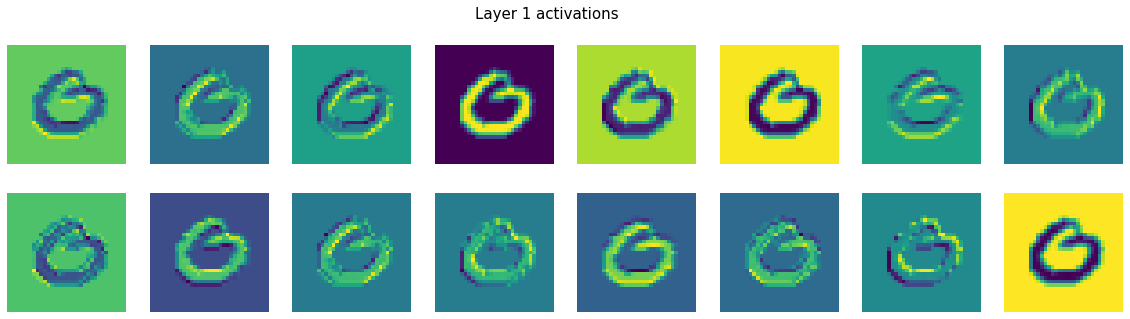

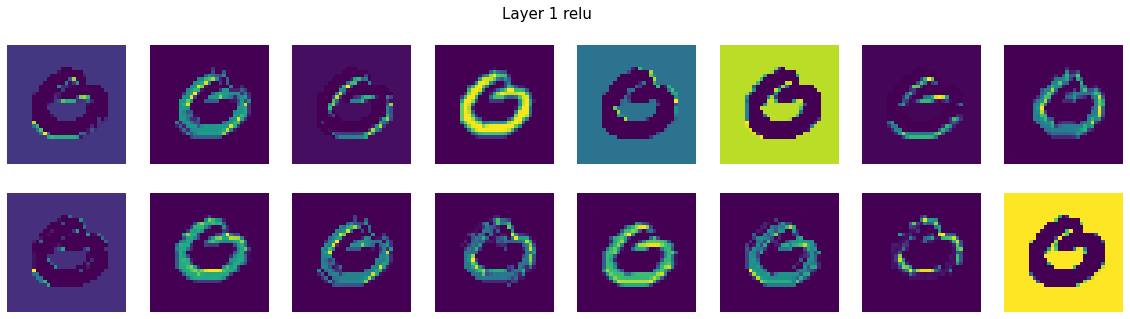

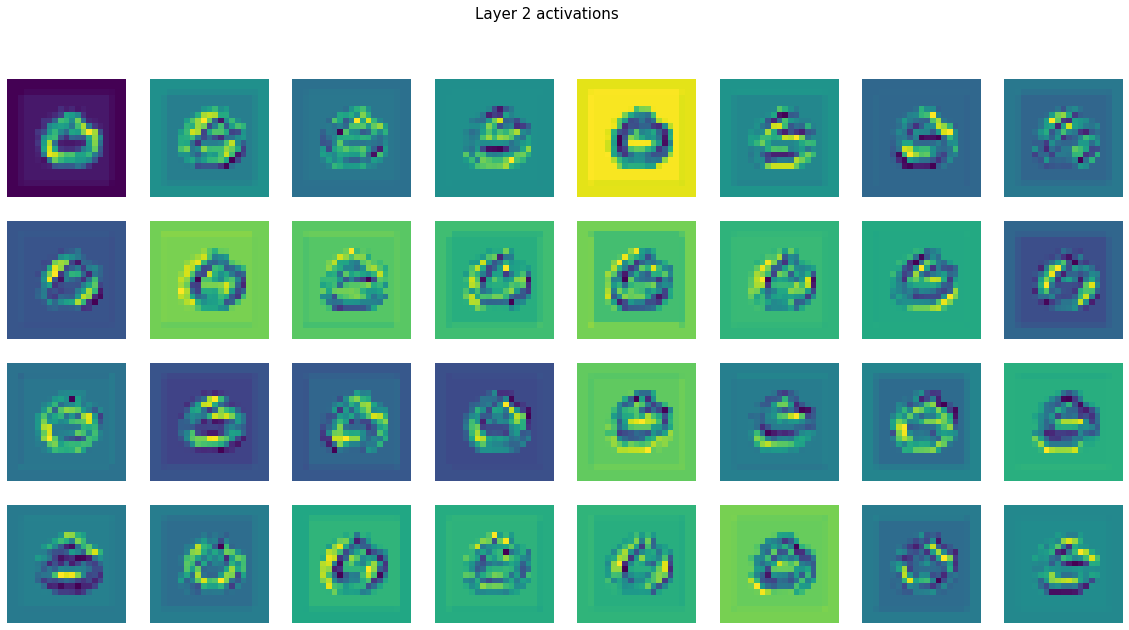

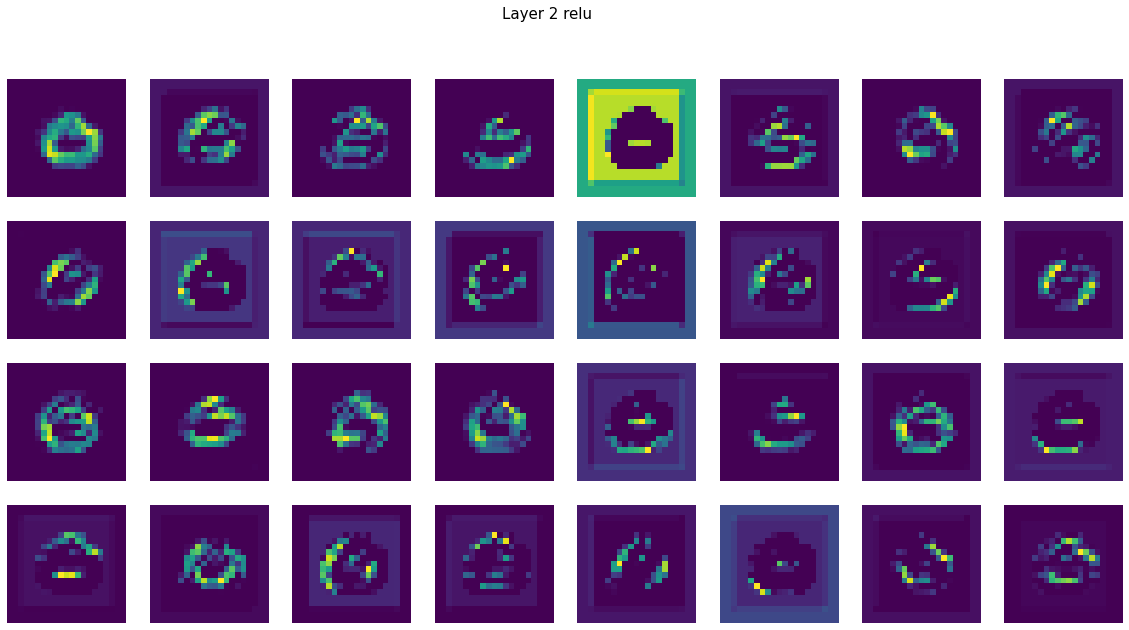

In [168]:
model.eval()
sample = train[np.random.randint(0,60000)][0].view(1,1,28,28)
layer1, relu1, layer2, relu2 = list(model.activations(sample))

plot_activations(layer1, 2, 8, 'Layer 1 activations', (20,5))
plot_activations(relu1, 2, 8, 'Layer 1 relu', (20,5))

plot_activations(layer2, 4, 8, 'Layer 2 activations', (20,10))
plot_activations(relu2, 4, 8, 'Layer 2 relu', (20,10))